# Welcome to Transfuser Workshop
In this workshop, we'll build Transfuser, an End-to-End Autonomous Driving model, from scratch, that can predict future waypoints, using camera and lidar data.

## Imports

In [1]:
!pip install torch==1.11.0+cpu torchvision==0.12.0+cpu --extra-index-url https://download.pytorch.org/whl/cpu
!pip install mmcv-full==1.5.3 -f https://download.openmmlab.com/mmcv/dist/cpu/torch1.11/index.html
!pip install mmdet==2.25.0 -f https://download.openmmlab.com/mmdet/dist/cpu/torch1.11/index.html

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 51.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.2+cpu
    Uninstalling torch-2.1.2+cpu:
      Successfully uninstalled torch-2.1.2+cpu
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.16.2+cpu
    Uninstalling torchvision-0.16.2+cpu:
      Successfully uninstalled torchvision-0.16.2+cpu
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 2.2.2 requires torch>=1.13.0, but you have torch 1.11.0+cpu which is incompatible.
stable-baselines3 2.1.0 requires torch>=1.13, but you have torch 1.11.0+cpu which is incompatible.
torchaudio 2.1.2+cpu requires torc

In [2]:
import os
import sys
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
sys.path.append('/kaggle/input/transfuser-e2e-scripts')

# torch imports
import torch
import torch.nn as nn

## CARLA dataset & dataloaders

In [3]:
from config import GlobalConfig
from data import CARLA_Data

config = GlobalConfig()
# root_dir = 
train_set = CARLA_Data(root='/kaggle/input/carla-e2e-driving-train-val/train', config=config, load_raw_lidar=True)
val_set = CARLA_Data(root='/kaggle/input/carla-e2e-driving-train-val/val', config=config, load_raw_lidar=True)
print(f"There are {len(train_set)} samples in training set, {len(val_set)} samples in validation set ")

100%|██████████| 20/20 [00:00<00:00, 34.77it/s]
There are 1954 samples in training set, 1783 samples in validation set 


Create pytorch style dataloaders

In [4]:
from torch.utils.data import DataLoader

g_cuda = torch.Generator(device='cpu')
g_cuda.manual_seed(torch.initial_seed())

# We need to seed the workers individually otherwise random processes 
# in the dataloader return the same values across workers!
def seed_worker(worker_id):
    # Torch initial seed is properly set across the different workers,
    # we need to pass it to numpy and random.
    worker_seed = (torch.initial_seed()) % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


dataloader_train = DataLoader(train_set, shuffle=True, batch_size=4, worker_init_fn=seed_worker, generator=g_cuda, num_workers=4)
dataloader_val   = DataLoader(val_set, shuffle=False, batch_size=4, worker_init_fn=seed_worker, generator=g_cuda, num_workers=4)

In [5]:
sample_data = next(iter(dataloader_train))
print(f"sample data is of type {type(sample_data)} and has following keys")

for k,v in sample_data.items():
    print(k, list(v.shape))

sample data is of type <class 'dict'> and has following keys
rgb [4, 3, 160, 704]
bev [4, 160, 160]
depth [4, 160, 704]
semantic [4, 160, 704]
speed [4]
x_command [4]
y_command [4]
target_point [4, 2]
target_point_image [4, 1, 256, 256]
raw_lidar [4, 10000, 3]
num_raw_lidar_points [4]
lidar [4, 2, 256, 256]
label [4, 20, 7]
ego_waypoint [4, 4, 2]


## Transfuser model

Primary inputs to Transfuser model are as follows:
- RGB image (3, 160, 704)
- Lidar BEV image (3, 256, 256)
- Desired speed (2)

Initial goal is to extract features from inputs using backbones. As both lidar and camera inputs are ~image representation, we can make use of pretrained backbones to do the same. Even if Lidar was represented as 3D point cloud, we can use extractors like `VoxelNet` or `PointNet` variants for doing so.

### Feature extraction Backbones

### RGB Image

(-0.5, 703.5, 159.5, -0.5)

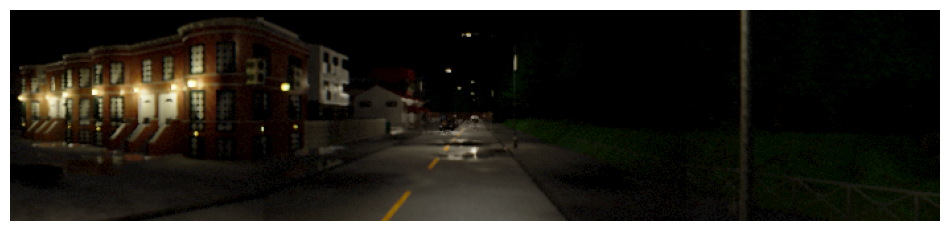

In [6]:
rgb_image = sample_data['rgb'][0].permute(1,2,0)
plt.figure(figsize = (12, 8))
plt.imshow(rgb_image)
plt.axis('off')

We'll use regnet32 backbone for both extracting image and lidar features. We'll make use of the `timm` library, for getting models, pretrained on large datasets, like Imagenet. We need 2 main inputs
- Name of architecture (eg: resnet18, resnet32). In our case, we'll use regnety032
- pretrained or not (boolean)

In [7]:
import timm

class ImageCNN(nn.Module):
    def __init__(self, architecture, normalize):
        super().__init__()
        self.normalize = normalize
        self.features = timm.create_model(architecture, pretrained=True)
        self.features.fc = None
        # Delete parts of the networks we don't want
        # Rename modules so we can use the same code
        self.features.conv1 = self.features.stem.conv
        self.features.bn1  = self.features.stem.bn
        self.features.act1 = nn.Sequential() #The Relu is part of the batch norm here.
        self.features.maxpool =  nn.Sequential()
        self.features.layer1 =self.features.s1
        self.features.layer2 =self.features.s2
        self.features.layer3 =self.features.s3
        self.features.layer4 =self.features.s4
        self.features.global_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.features.head = nn.Sequential()

In [8]:
image_encoder = ImageCNN(architecture='regnety_032', normalize=True)
# print(image_encoder)

model.safetensors:   0%|          | 0.00/78.1M [00:00<?, ?B/s]

Notice that we have 4 primary layers in the backbone. We'll go through each layer, one by one, for us to fuse with corresponding lidar features. 

In [9]:
test_rgb_input = sample_data['rgb'][0:1, :, :, :]

# normalize using imagenet values
def normalize_imagenet(x):
    x = x.clone()
    x[:, 0] = ((x[:, 0] / 255.0) - 0.485) / 0.229
    x[:, 1] = ((x[:, 1] / 255.0) - 0.456) / 0.224
    x[:, 2] = ((x[:, 2] / 255.0) - 0.406) / 0.225
    return x

test_rgb_input = normalize_imagenet(test_rgb_input).float()

In [10]:
# one time operation, initial conv layer
image_features = image_encoder.features.conv1(test_rgb_input)
image_features = image_encoder.features.bn1(image_features)
image_features = image_encoder.features.act1(image_features)
image_features = image_encoder.features.maxpool(image_features)
print(f"Image features shape after 1st stem = {image_features.shape}")

image_features = image_encoder.features.layer1(image_features)
print(f"Layer1 Image features shape = {image_features.shape}")

Image features shape after 1st stem = torch.Size([1, 32, 80, 352])
Layer1 Image features shape = torch.Size([1, 72, 40, 176])


We'll visualize some of the learned features for the given image input

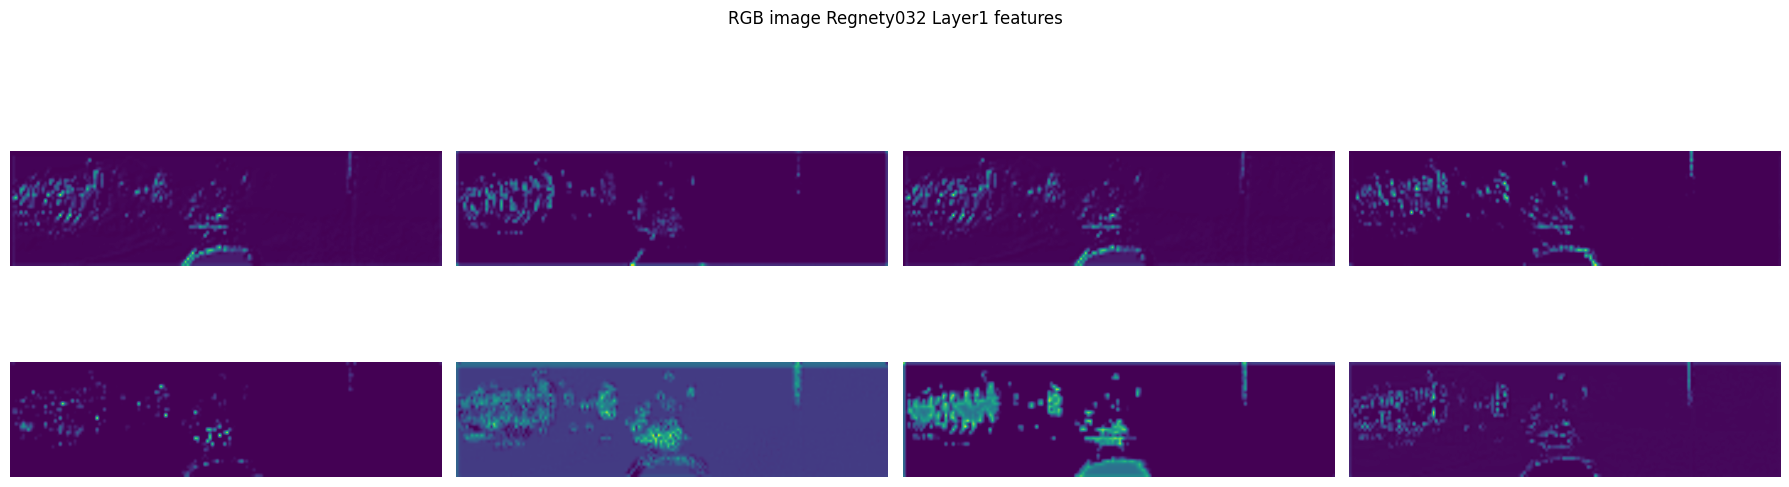

In [11]:
# select random channels from input
indices = np.random.randint(0, image_features.shape[1], size=8)

import cv2
fig, axes = plt.subplots(2,4, figsize= (18, 6)) 
axes = axes.flatten()
for i in range(len(indices)):
    feature_map = image_features[0, indices[i]].detach().cpu().numpy()
    feature_map = cv2.resize(feature_map, (1200, 320), interpolation = cv2.INTER_LINEAR)
    axes[i].imshow(feature_map)
    axes[i].axis('off')
plt.suptitle('RGB image Regnety032 Layer1 features');
plt.tight_layout();

We'll use layers2-4 in same way as above to generate features from rgb image

#### Lidar Point cloud

Next, we'll look at lidar point cloud data, to be used as input to model

In [12]:
num_lidar_points = sample_data['num_raw_lidar_points'][0]
lidar_data = sample_data['raw_lidar'][0][:num_lidar_points]
print(lidar_data.shape)

torch.Size([4935, 3])


In [13]:
import plotly.graph_objects as go
from utils import plot_pc_data3d

PCD_SCENE=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False,),
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=0.1),
)

pc_plots = plot_pc_data3d(x=lidar_data[:,0], y=lidar_data[:,1], z=lidar_data[:,2])
layout = dict(template="plotly_dark", title="Raw Point cloud", scene=PCD_SCENE, title_x=0.5)
fig = go.Figure(data=pc_plots, layout=layout)   
fig.show()

In transfuser model, we generate histogram features from the point cloud (one channel for above ground features, another for below ground) and use a CNN backbone to extract features. We have the histogram feature stored in **lidar** key

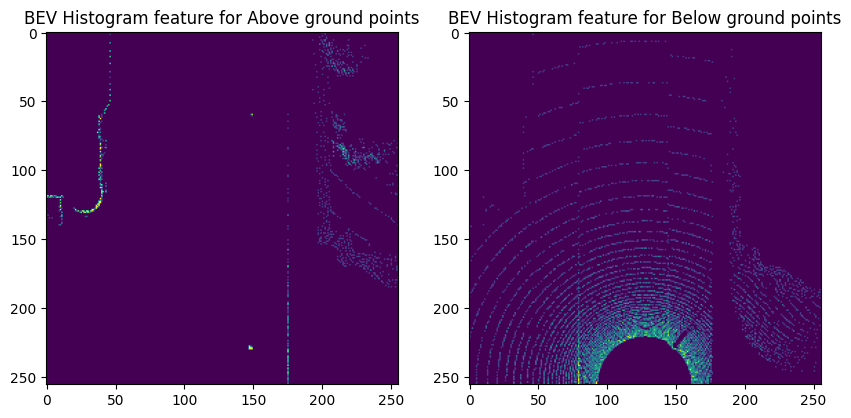

In [14]:
lidars_pc = sample_data['lidar'][0]
fig, ax  = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(lidars_pc[0]);
ax[0].set_title("BEV Histogram feature for Above ground points");
ax[1].imshow(lidars_pc[1]);
ax[1].set_title("BEV Histogram feature for Below ground points");

Apart from lidar point cloud features, we also convert the target point to BEV space and concat that as 3rd channel

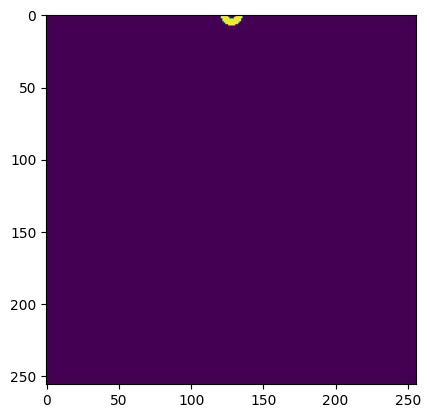

In [15]:
tgt_pt_in_lidar = sample_data['target_point_image'][0]
plt.imshow(tgt_pt_in_lidar[0]);

In [16]:
class LidarEncoder(nn.Module):
    def __init__(self, architecture, in_channels=3):
        super().__init__()

        self._model = timm.create_model(architecture, pretrained=False)
        self._model.fc = None

        # Rename modules so we can use the same code
        self._model.conv1 = self._model.stem.conv
        self._model.bn1  = self._model.stem.bn
        self._model.act1 = nn.Sequential()
        self._model.maxpool =  nn.Sequential()
        self._model.layer1 = self._model.s1
        self._model.layer2 = self._model.s2
        self._model.layer3 = self._model.s3
        self._model.layer4 = self._model.s4
        self._model.global_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self._model.head = nn.Sequential()

        # Change the first conv layer so that it matches the amount of channels in the LiDAR
        # Timm might be able to do this automatically
        _tmp = self._model.conv1
        use_bias = (_tmp.bias != None)
        self._model.conv1 = nn.Conv2d(in_channels, out_channels=_tmp.out_channels,
            kernel_size=_tmp.kernel_size, stride=_tmp.stride, padding=_tmp.padding, bias=use_bias)
        # Need to delete the old conv_layer to avoid unused parameters
        del self._model.stem.conv
        torch.cuda.empty_cache()
        del _tmp

In [17]:
lidar_encoder = LidarEncoder(architecture='regnety_032')
#print(lidar_encoder)

In [18]:
test_lidar_input = torch.cat((lidars_pc, tgt_pt_in_lidar), dim=0).unsqueeze(0).float()

# one time operation, initial conv layer
lidar_features = image_encoder.features.conv1(test_lidar_input)
lidar_features = image_encoder.features.bn1(lidar_features)
lidar_features = image_encoder.features.act1(lidar_features)
lidar_features = image_encoder.features.maxpool(lidar_features)
print(f"Lidar features shape after 1st stem = {lidar_features.shape}")

lidar_features = image_encoder.features.layer1(lidar_features)
print(f"Layer1 Lidar features shape = {lidar_features.shape}")

Lidar features shape after 1st stem = torch.Size([1, 32, 128, 128])
Layer1 Lidar features shape = torch.Size([1, 72, 64, 64])


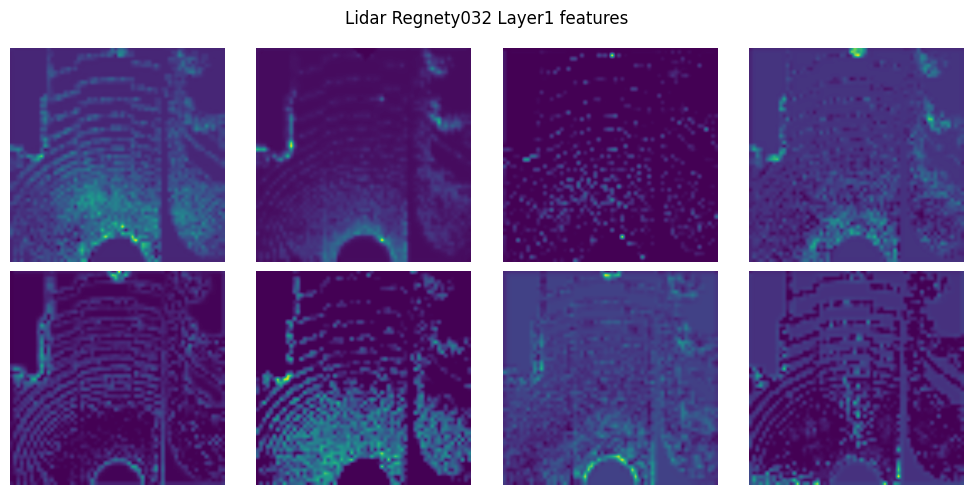

In [19]:
# select random channels from input
indices = np.random.randint(0, lidar_features.shape[1], size=8)

fig, axes = plt.subplots(2,4, figsize= (10, 5)) 
axes = axes.flatten()
for i in range(len(indices)):
    feature_map = lidar_features[0, indices[i]].detach().cpu().numpy()
    feature_map = cv2.resize(feature_map, (512, 512), interpolation = cv2.INTER_LINEAR)
    axes[i].imshow(feature_map)
    axes[i].axis('off')
plt.suptitle('Lidar Regnety032 Layer1 features');
plt.tight_layout();

### Sensor Fusion using GPT (General Purpose Transformer)

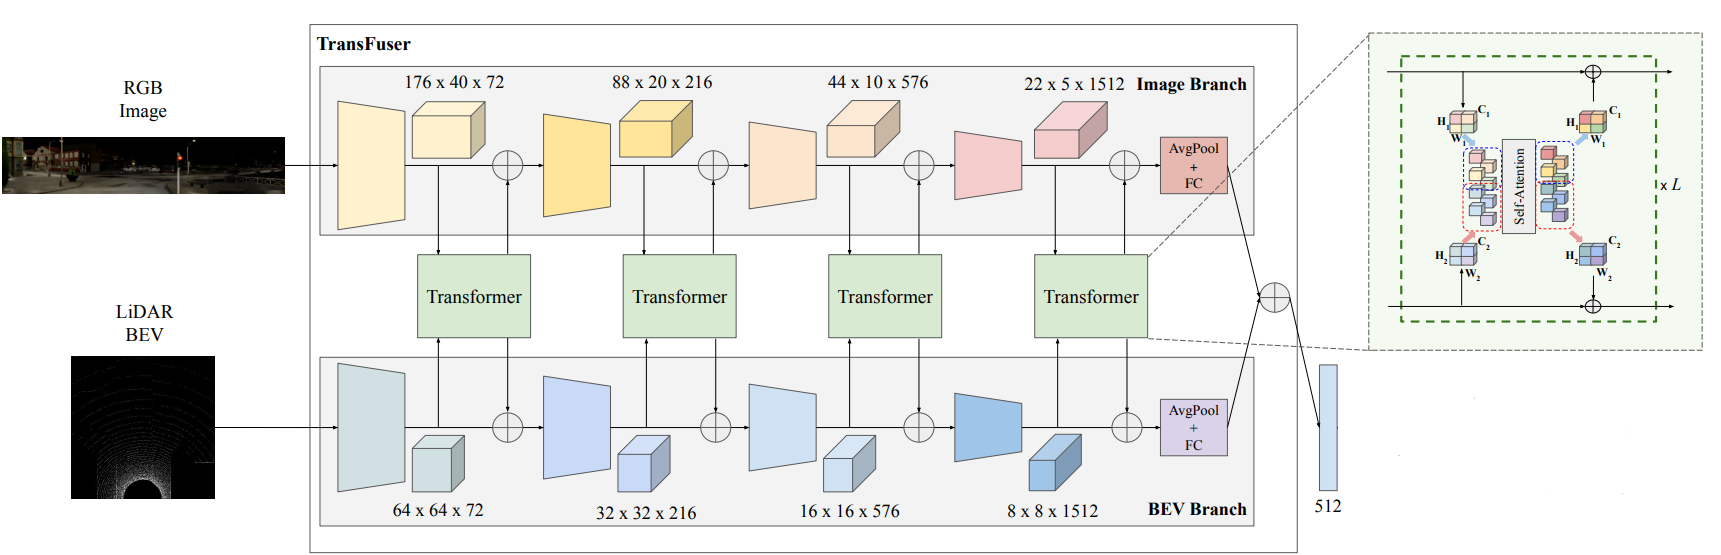

Next step is to fuse the image data with Lidar data. This usually, happens in the BEV (Bird's Eye view space). BEV offers elegant solution to fuse the perspective data of front facing camera and Top down view of point cloud. In the Transfuser paper, they use a `GPT (General Purpose Transformer)` module, which correlates different sensor data via `Self-attention` mechanism

We'll first define a Self Attention module

In [20]:
import math
import torch.nn.functional as F

class SelfAttention(nn.Module):
    # A vanilla multi-head masked self-attention layer with a projection at the end.
    def __init__(self, n_embd, n_head, attn_pdrop, resid_pdrop):
        super().__init__()
        assert n_embd % n_head == 0
        # key, query, value projections for all heads
        self.key = nn.Linear(n_embd, n_embd)
        self.query = nn.Linear(n_embd, n_embd)
        self.value = nn.Linear(n_embd, n_embd)
        # regularization
        self.attn_drop = nn.Dropout(attn_pdrop)
        self.resid_drop = nn.Dropout(resid_pdrop)
        # output projection
        self.proj = nn.Linear(n_embd, n_embd)
        self.n_head = n_head

        # attention map
        self.attn_map = None

    def forward(self, x):
        B, T, C = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = F.softmax(att, dim=-1)
        self.attn_map = att.detach().cpu().numpy()
        att = self.attn_drop(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_drop(self.proj(y))
        return y

In [21]:
test_attention_input = torch.randn((1, 174, 72))
self_attention_module = SelfAttention(n_embd=72, n_head=4, attn_pdrop=0.1, resid_pdrop=0.1)
self_attention_output = self_attention_module(test_attention_input)
print(f"Self Attention output shape = {self_attention_output.shape}")

Self Attention output shape = torch.Size([1, 174, 72])


A Transformer block, consists of an Attention module, FeedForward network with Normalization layers inbetween

In [22]:
class Block(nn.Module):
    def __init__(self, n_embd, n_head, block_exp, attn_pdrop, resid_pdrop):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.attn = SelfAttention(n_embd, n_head, attn_pdrop, resid_pdrop)
        self.mlp = nn.Sequential(
            nn.Linear(n_embd, block_exp * n_embd),
            nn.ReLU(True), # changed from GELU
            nn.Linear(block_exp * n_embd, n_embd),
            nn.Dropout(resid_pdrop),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

In [23]:
test_block_input = torch.randn((1, 174, 72))
block = Block(n_embd=72, n_head=4, block_exp=4, attn_pdrop=0.1, resid_pdrop=0.1)
block_output = block(test_block_input)
print(f"Transformer block output shape = {block_output.shape}")

Transformer block output shape = torch.Size([1, 174, 72])


Next, we'll stack number of these blocks, to form a GPT module. 

**Inputs**
- Lidar feature at particular layer (batch_size * 4 *seq len, C, H, W)
- Image feature at particular layer (batch_size seq len, C, H, W)

**Outputs**
- Fused Lidar feature (batch_size * 4 *seq len, C, H, W)
- Fused Image feature (batch_size * 4 *seq len, C, H, W)


The GPT module, concatenates the inputs to single token, adds Position encoding to inputs and passes through blocks to get the fused output

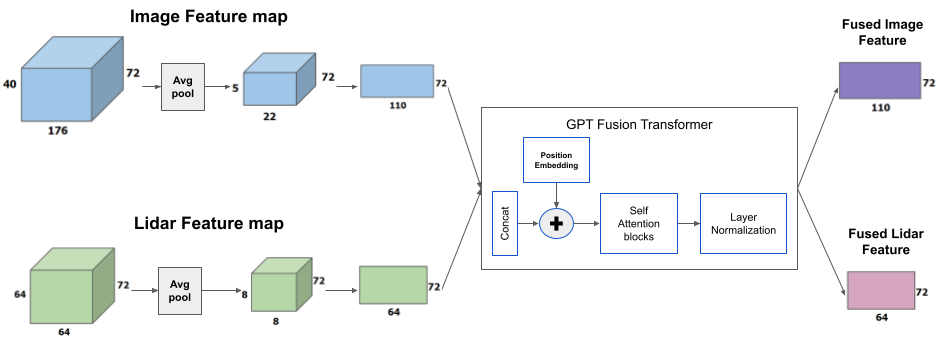

In [24]:
class GPT(nn.Module):
    def __init__(self, n_embd, n_head, block_exp, n_layer, 
                    img_vert_anchors, img_horz_anchors, 
                    lidar_vert_anchors, lidar_horz_anchors,
                    embd_pdrop, attn_pdrop, resid_pdrop):
        super().__init__()
        self.n_embd = n_embd
        self.img_vert_anchors = img_vert_anchors
        self.img_horz_anchors = img_horz_anchors
        self.lidar_vert_anchors = lidar_vert_anchors
        self.lidar_horz_anchors = lidar_horz_anchors
        self.seq_len = 1
        
        # positional embedding parameter (learnable), image + lidar
        self.pos_emb = nn.Parameter(torch.zeros(1, 
                                                self.seq_len * img_vert_anchors * img_horz_anchors + \
                                                self.seq_len * lidar_vert_anchors * lidar_horz_anchors,
                                                n_embd))
        
        self.drop = nn.Dropout(embd_pdrop)

        # transformer
        self.blocks = nn.Sequential(*[Block(n_embd, n_head, 
                        block_exp, attn_pdrop, resid_pdrop)
                        for _ in range(n_layer)])
        
        # decoder head
        self.ln_f = nn.LayerNorm(n_embd)
        self.block_size = self.seq_len

    def forward(self, image_tensor, lidar_tensor):
        bz = lidar_tensor.shape[0]
        lidar_h, lidar_w = lidar_tensor.shape[2:4]
        img_h, img_w = image_tensor.shape[2:4]
        
        assert self.seq_len == 1
        image_tensor = image_tensor.view(bz, self.seq_len, -1, img_h, img_w).permute(0,1,3,4,2).contiguous().view(bz, -1, self.n_embd)
        lidar_tensor = lidar_tensor.view(bz, self.seq_len, -1, lidar_h, lidar_w).permute(0,1,3,4,2).contiguous().view(bz, -1, self.n_embd)

        token_embeddings = torch.cat((image_tensor, lidar_tensor), dim=1)

        x = self.drop(self.pos_emb + token_embeddings)
        x = self.blocks(x) # (B, an * T, C)
        x = self.ln_f(x) # (B, an * T, C)

        x = x.view(bz, self.seq_len*self.img_vert_anchors*self.img_horz_anchors + self.seq_len*self.lidar_vert_anchors*self.lidar_horz_anchors, self.n_embd)

        image_tensor_out = x[:, :self.seq_len*self.img_vert_anchors*self.img_horz_anchors, :].contiguous().view(bz * self.seq_len, -1, img_h, img_w)
        lidar_tensor_out = x[:, self.seq_len*self.img_vert_anchors*self.img_horz_anchors:, :].contiguous().view(bz * self.seq_len, -1, lidar_h, lidar_w)

        return image_tensor_out, lidar_tensor_out


- The feature maps from backbones can be pretty large, and computing attention b/w entire lidar and image maps can be expensive, particularly, when using vanilla self-attention
- Hence, we downscale them to a lesser resolution, before passing to transformer modules
- We'll make use of **Average Pooling** modules, for downscaling feature maps from backbones

In [25]:
avgpool_img = nn.AdaptiveAvgPool2d((5, 22))
avgpool_lidar = nn.AdaptiveAvgPool2d((8, 8))

# downscale the feature maps
image_layer1_feature = avgpool_img(image_features)
lidar_layer1_feature = avgpool_lidar(lidar_features)

In [26]:
transformer_module = GPT(n_embd=72, n_head=4, block_exp=4, n_layer=4,
                         img_vert_anchors =5, img_horz_anchors=22,
                         lidar_vert_anchors=8, lidar_horz_anchors=8, 
                         embd_pdrop=0.1, attn_pdrop=0.1, resid_pdrop=0.1)
fused_image_features, fused_lidar_features = transformer_module(image_layer1_feature, lidar_layer1_feature)
print(f"Transformer output Fused Image features = {fused_image_features.shape}")
print(f"Transformer output Fused Lidar features = {fused_lidar_features.shape}")

Transformer output Fused Image features = torch.Size([1, 72, 5, 22])
Transformer output Fused Lidar features = torch.Size([1, 72, 8, 8])


**NOTE**: 
- Lidar layer1 output shape = (1, 72, 64, 64)
- Fused Lidar layer1 transformer output shape = (1, 72, 8, 8)
- Image layer1 output shape = (1, 72, 40, 176)
- Fused Image layer1 transformer output shape = (1, 72, 5, 22)

Apart from fusing lidar and camera images using Transformer blocks, we can add `Residual` connections b/w the original layer1 output and the fused output for each modality. This is similar to **Multi-scale fusion using FPN**

Idea is to upsample the fused output using bilinear interpolation and add it to original output

In [27]:
image_features_layer1 = F.interpolate(fused_image_features, size=(image_features.shape[2],image_features.shape[3]), mode='bilinear', align_corners=False)
lidar_features_layer1 = F.interpolate(fused_lidar_features, size=(lidar_features.shape[2],lidar_features.shape[3]), mode='bilinear', align_corners=False)
image_features = image_features + image_features_layer1
lidar_features = lidar_features + lidar_features_layer1

print(f"Image features shape after layer1 fusion = {image_features.shape}")
print(f"Lidar features shape after layer1 fusion = {lidar_features.shape}")

Image features shape after layer1 fusion = torch.Size([1, 72, 40, 176])
Lidar features shape after layer1 fusion = torch.Size([1, 72, 64, 64])


The above feature extraction and fusion b/w lidar and image data is repeated 4 times (4 layers) in the same manner. The output shapes at each layer are as follows:

- | Layer  | Lidar feature shape | Image feature shape |
- | Layer1 | (1, 72, 64, 64) | (1, 72, 40, 176) |
- | Layer2 | (1, 216, 32, 32) | (1, 216, 20, 88) |
- | Layer3 | (1, 576, 16, 16) | (1, 576, 10, 44) |
- | Layer4 | (1, 1512, 8,   8) | (1, 1512, 5, 22) |

We have a small final piece of fusion module, that represents all that the network has learnt, from the sensor inputs. We need to combine the lidar and image feature maps from the last layer, to be passed on to the planning module. We'll use the following steps:
- Use 1x1 convolutions to reduce the channel dimension
- Reduce the spatial dimension using AdaptiveAveragePooling

In [28]:
test_layer4_image_output = torch.randn(1, 1512, 5, 22)
test_layer4_lidar_output = torch.randn(1, 1512, 8, 8)

# reduce channel dimension
final_image_conv = nn.Conv2d(1512, 512, kernel_size=1, padding=0)
final_lidar_conv = nn.Conv2d(1512, 512, kernel_size=1, padding=0)
image_features = final_image_conv(test_layer4_image_output)
lidar_features = final_lidar_conv(test_layer4_lidar_output)

# reduce spatial dimension, we'll use the pooling 
# layers from image and lidar encoder networks
image_features = image_encoder.features.global_pool(image_features)
image_features = torch.flatten(image_features, 1)

lidar_features = lidar_encoder._model.global_pool(lidar_features)
lidar_features = torch.flatten(lidar_features, 1)
fused_features = image_features + lidar_features
print(f"Lidar features shape = {lidar_features.shape}, Image features shape = {image_features.shape}")
print(f"Fused features shape = {fused_features.shape}")

Lidar features shape = torch.Size([1, 512]), Image features shape = torch.Size([1, 512])
Fused features shape = torch.Size([1, 512])


### Planning

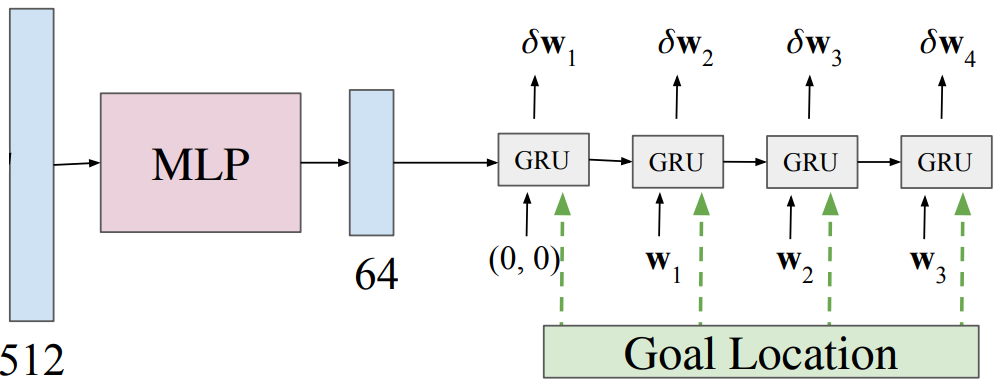

Goal of planning module is to predict the future waypoints, to be followed by the vehicle.

**Input**
- BEV Fused Features, extracted from Perception module (512,)
- Waypoints, predicted from previous timestamp (for first timestamp, we input zero values) (2,)
- Target Waypoint (2,)

**Output**
- Future Waypoints in vehicle coordinate frame

We use a simple MLP + GRU network, to predict the future points, one by one. 

In [29]:
# Simple MLP layer to reduce feature dimension
proj1 = nn.Sequential(
                    nn.Linear(512, 256),
                    nn.ReLU(inplace=True),
                    nn.Linear(256, 128),
                    nn.ReLU(inplace=True),
                    nn.Linear(128, 64),
                    nn.ReLU(inplace=True),
                )

# input = (prev_points, target_point)
decoder = nn.GRUCell(input_size=4, hidden_size=64)

# output projection layer
output = nn.Linear(64, 3)

In [30]:
test_planning_input = torch.randn(1,512)
target_point = torch.randn(1,2)
bs = test_planning_input.shape[0]

# number of future trajectory points, 
# we want to predict w.r.t vehicle
num_steps = 4

In [31]:
z = proj1(test_planning_input)

output_wp = list()

# initial input variable to GRU
x = torch.zeros(size=(bs, 2), dtype=z.dtype)

# autoregressive generation of output waypoints
for _ in range(num_steps):
    x_in = torch.cat([x, target_point], dim=1)
    z = decoder(x_in, z)
    dx = output(z)
    x = dx[:,:2] + x
    output_wp.append(x[:,:2])

pred_wp = torch.stack(output_wp, dim=1)
print(pred_wp.shape)

torch.Size([1, 4, 2])


Now that we have the predicted trajectory, we can compute the loss. Commonly used loss functions include **Smooth L1 Loss, L1 Loss, L2 loss and weighted averages of these**. We'll use the L1 Loss function

In [32]:
test_ego_waypoint = torch.randn(1, num_steps, 2)
loss_wp = torch.mean(torch.abs(pred_wp - test_ego_waypoint))
print(f"L1 loss b/w predicted and actual trajectory = {loss_wp.item() : 0.4f}")

L1 loss b/w predicted and actual trajectory =  0.6572


### Auxillary tasks

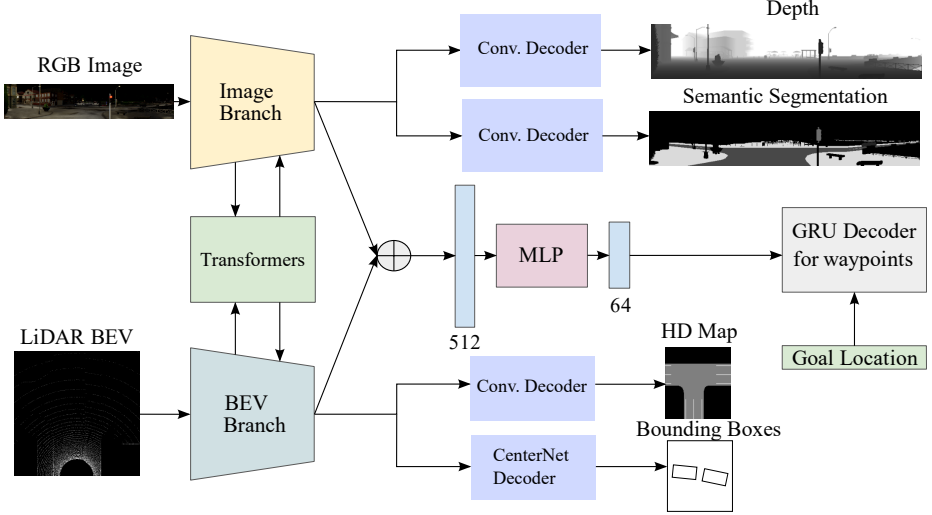

The above modules form the crux of the `Transfuser` model, which is executed during inference. Experiments have shown model convergence and performance to improve, with addition of auxilary tasks, during training. In this model, authors have used
- 3D Object detection
- Depth estimation
- Semantic Segmentation
- HD Map prediction (in BEV space)

as auxillary tasks. These many tasks were possible, due to training data being generated from CARLA simulator. All these might not be possible in real life datasets, due to practical difficulties, but it definitely helps to have such tasks

**NOTE**: 
- The last layer image and lidar feature maps are used as input for each of these tasks (akin to different heads in Hydranet)
- The losses from each of auxilary tasks are combined with main loss (L1 on waypoint prediction) using weighted average. The weights are hyperparameters for the model

### Putting it together

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

from model import LidarCenterNet
model = LidarCenterNet(config, device, config.backbone, image_architecture='regnety_032', 
                           lidar_architecture='regnety_032')
model.to(device);

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print ('Total trainable parameters: ', params)

Total trainable parameters:  168018327


## Training utilities

In [34]:
def train_validate_model(model, num_epochs, model_name, optimizer, 
                         device, dataloader_train, dataloader_valid, 
                         lr_scheduler = None, output_path = '.'):

    # initialize placeholders for running values
    train_results = []    
    val_results = []    
    min_val_loss = np.Inf

    # move model to device
    model.to(device)
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        epoch_detailed_train_losses  = {key: 0.0 for key in config.detailed_losses}
        epoch_detailed_train_losses['weighted_loss'] = 0.0
        
        with tqdm(dataloader_train, unit="batch") as tepoch:
            for batch_idx, data in enumerate(tepoch):
                tepoch.set_description(f"Epoch {epoch}")

                # load data to gpu, according to type
                for k in ['rgb', 'depth', 'lidar', 'label', 'ego_waypoint', \
                          'target_point', 'target_point_image', 'speed']:
                    data[k] = data[k].to(device, torch.float32)
                for k in ['semantic', 'bev']:
                    data[k] = data[k].to(device, torch.long)
                
                # forward pass, store losses
                losses, _ = model(data)
                loss = torch.tensor(0.0).to(device, dtype=torch.float32)
                for key, value in losses.items():
                    loss += detailed_weights[key] * value
                    epoch_detailed_train_losses[key] += float(detailed_weights[key] * value.item())
                epoch_detailed_train_losses['weighted_loss'] += float(loss.item())
                
                # backward pass
                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()
                
                # log losses
                tepoch.set_postfix(loss=loss.item())
                
                if batch_idx == 2:
                    break
                    
            # average losses across batches
            for k,v in epoch_detailed_train_losses.items():
                epoch_detailed_train_losses[k] = v / len(dataloader_train)
            
        train_results.append(epoch_detailed_train_losses)
    
    return train_results, val_results

## Training

In [35]:
import torch.optim as optim
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

N_EPOCHS = 3

detailed_weights = {key: config.detailed_losses_weights[idx] for idx, key in enumerate(config.detailed_losses)}

train_results, val_results = train_validate_model(model, num_epochs=N_EPOCHS, model_name='Transfuser_regnet032', 
                                                  optimizer=optimizer,device = device, dataloader_train=dataloader_train, 
                                                  dataloader_valid = dataloader_val)

import pandas as pd
train_results = pd.DataFrame(train_results)
train_results.to_csv(f'Transfuser_regnet032y_{N_EPOCHS}.pth')

Epoch 0:   0%|          | 0/489 [00:01<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/mmdet/models/utils/gaussian_target.py:227: UserWarning:

__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').

/opt/conda/lib/python3.10/site-packages/mmdet/models/utils/gaussian_target.py:229: UserWarning:

__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').

Epoch 2:   0%|          | 2

In [36]:
train_results

,loss_wp,loss_bev,loss_depth,loss_semantic,loss_center_heatmap,loss_wh,loss_offset,loss_yaw_class,loss_yaw_res,loss_velocity,loss_brake,weighted_loss
0,0.013583,0.006620,0.018719,0.011722,0.692369,0.000761,0.000711,0.011861,0.000003,0.0,0.0,0.756349
1,0.013043,0.006609,0.019141,0.011605,1.164540,0.000746,0.000737,0.011856,0.000003,0.0,0.0,1.228281
2,0.014087,0.006611,0.017740,0.011393,1.098591,0.000695,0.000660,0.011901,0.000001,0.0,0.0,1.161678


In [37]:
import plotly.graph_objects as go

# Create traces
fig = go.Figure()

for key in config.detailed_losses + ['weighted_loss']: 
    fig.add_trace(go.Scatter(x=np.arange(len(train_results)), y=train_results[key],
                        mode='lines', name=f'{key.replace("loss_", "")}_TR'))

fig.update_layout(title='Transfuser with regnet032y backbone',width=1200, height=600, 
                  xaxis_title='Epoch', yaxis_title='Loss components')    
fig.show()